In [8]:
import torch
from diffusers import LCMScheduler, AutoPipelineForText2Image

model_id = "stabilityai/stable-diffusion-xl-base-1.0"
adapter_id = "latent-consistency/lcm-lora-sdxl"

pipe = AutoPipelineForText2Image.from_pretrained(model_id, torch_dtype=torch.float16, variant="fp16")
pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

# load and fuse lcm lora
pipe.load_lora_weights(adapter_id)
pipe.fuse_lora()


prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"

# disable guidance_scale by passing 0
image = pipe(prompt=prompt, num_inference_steps=4, guidance_scale=0).images[0]


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'skip_prk_steps': True} were passed to LCMScheduler, but are not expected and will be ignored. Please verify your scheduler_config.json configuration file.


  0%|          | 0/4 [00:00<?, ?it/s]

In [2]:
from pruna.algorithms.smasher_config import AutoSmasherConfig
from pruna.smash import smash

Post-training Optimization Tool is deprecated and will be removed in the future. Please use Neural Network Compression Framework instead: https://github.com/openvinotoolkit/nncf
Nevergrad package could not be imported. If you are planning to use any hyperparameter optimization algo, consider installing it using pip. This implies advanced usage of the tool. Note that nevergrad is compatible only with Python 3.7+


In [3]:
from pruna.algorithms.smasher_config import SmasherConfig

smasher_config = SmasherConfig()
smasher_config['compiler'] = 'diffusers'
smasher_config['max_batch_size'] = 1
smasher_config['image_height'] = 1024
smasher_config['image_width'] = 1024
smasher_config['version'] = 'xl-1.0'
smasher_config['scheduler'] = "LCMScheduler"

In [4]:
smashed_model = smash(
        model=pipe,
        data_module="LAION256",
        api_key='your-api-key',
        model_config=None,
        smasher_config=smasher_config,
        device='cuda',
    )

[ WARNING ] Found cached dataset parquet (/nfs/homedirs/rachwan/.cache/huggingface/datasets/nannullna___parquet/nannullna--laion_subset-23ff82ebc89d23ff/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/3 [00:00<?, ?it/s]

Compile...
[I] Load tokenizer pytorch model from: .cache/torch/xl-1.0/SD_XL_BASE/tokenizer_2
[I] Load tokenizer pytorch model from: /nfs/students/rachwan/huggingface/.cache/torch/xl-1.0/SD_XL_BASE/tokenizer
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/clip.plan
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/clip2.plan
Loading TensorRT engine: /nfs/students/rachwan/huggingface/.cache/engine/unetxl.plan
Success.


CPU times: user 852 ms, sys: 70.1 ms, total: 922 ms
Wall time: 920 ms


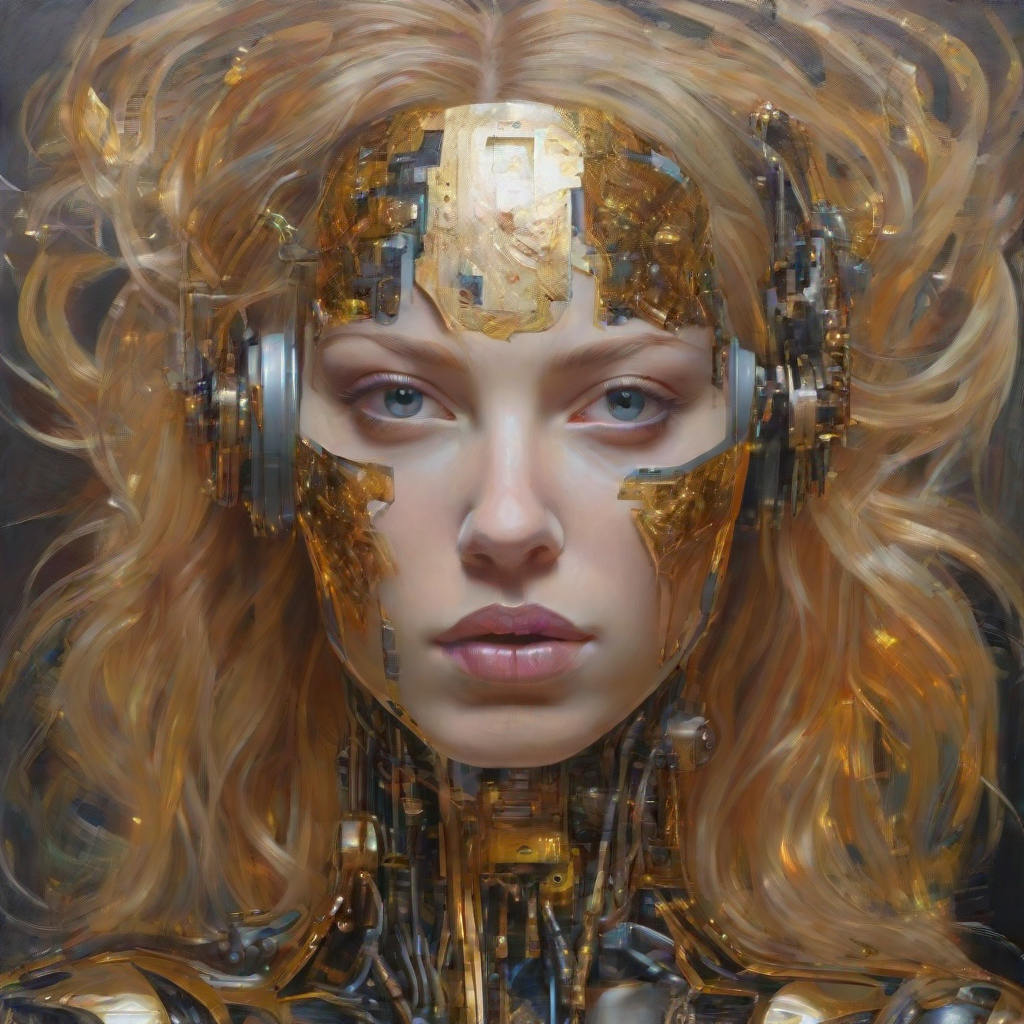

In [7]:
%%time
smashed_model(prompt, num_inference_steps=4, image_height=1024, image_width=1024, guidance_scale=1.0)[0]

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 1.09 s, sys: 0 ns, total: 1.09 s
Wall time: 1.08 s


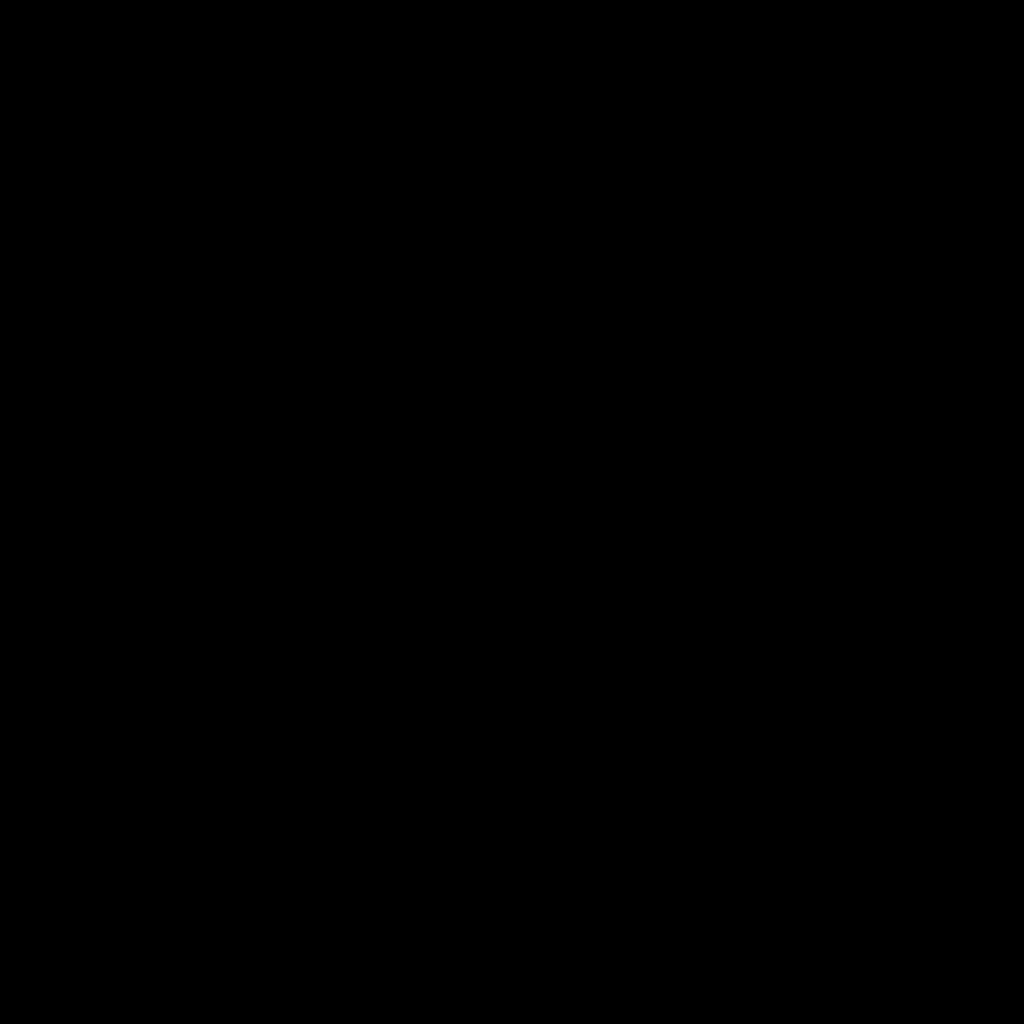

In [14]:
%%time
pipe(prompt, num_inference_steps=4, guidance_scale=0).images[0]